In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchxrayvision as xrv
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score


def load_image_list(file_path):
    with open(file_path, 'r') as f:
        return set(line.strip() for line in f)


train_val_image_set = load_image_list('train_val_list.txt')
test_image_set = load_image_list('test_list.txt')


dataset = xrv.datasets.NIH_Dataset(
    imgpath='images/', 
    csvpath='dataset/Data_Entry_2017.csv',
    unique_patients=False,
    views=['PA', 'AP'],
)

transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)
])
dataset.transform = transform

print("Done!")

/home/katsiarynl/.local/lib/python3.10/site-packages/torchxrayvision/utils.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Done!


In [ ]:
def filter_dataset_by_image_list(dataset, image_set):
    filtered_idxs = [i for i in range(len(dataset)) if os.path.basename(dataset.csv.iloc[i]["Image Index"]) in image_set]
    return xrv.datasets.SubsetDataset(dataset, filtered_idxs)


train_val_dataset = filter_dataset_by_image_list(dataset, train_val_image_set)
test_dataset = filter_dataset_by_image_list(dataset, test_image_set)

print(f"Training/Validation dataset size: {len(train_val_dataset)}")

df_train = train_val_dataset.csv  
patients = df_train['Patient ID'].unique()  

train_patients, val_patients = train_test_split(
    patients, test_size=0.15, random_state=42  
)

train_indices = [
    idx for idx in range(len(train_val_dataset))
    if df_train.iloc[idx]['Patient ID'] in train_patients
]
val_indices = [
    idx for idx in range(len(train_val_dataset))
    if df_train.iloc[idx]['Patient ID'] in val_patients
]

train_dataset = Subset(train_val_dataset, train_indices)
val_dataset = Subset(train_val_dataset, val_indices)


print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training/Validation dataset size: 86524
Training dataset size: 73916
Validation dataset size: 12608
Testing dataset size: 25596


In [3]:
batch_size = 32
num_workers = 64
pin_memory = True

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5)
  
        self.fc1 = nn.Linear(24 * 53 * 53, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 14)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN()

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
thresholds = torch.tensor(
    [0.039117552, 0.0034529066, 0.11396341, 0.0057298196, 0.00045666535, 0.0018880932,
     0.012037827, 0.038744126, 0.0037213727, 0.014730946, 0.016149804, 0.054241467,
     0.037198864, 0.0004403434], 
    device=device
)

# The class names needs to correspond to the thresholds defined
class_names = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []
val_precisions = []
val_recalls = []
val_f1s = []
auc_scores = []

train_class_accuracies = [[] for _ in range(len(class_names))]
val_class_accuracies = [[] for _ in range(len(class_names))]

num_epochs = 30
print("Start")
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    train_correct_per_class = [0] * len(class_names)
    train_total_per_class = [0] * len(class_names)


    for batch in train_loader:
        images = batch["img"].to(device)
        labels = batch["lab"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
  
        preds = (probabilities > thresholds).float()  
        correct += (preds == labels).sum().item()
        total += labels.numel()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        
        for i in range(len(class_names)):
            train_correct_per_class[i] += ((preds[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
            train_total_per_class[i] += (labels[:, i] == 1).sum().item()

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    train_epoch_class_accuracies = [
        correct / total if total > 0 else 0
        for correct, total in zip(train_correct_per_class, train_total_per_class)
    ]
    for i in range(len(class_names)):
        train_class_accuracies[i].append(train_epoch_class_accuracies[i])

    # Validate on the validation dataset
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_preds_val = []
    all_labels = []
    val_correct_per_class = [0] * len(class_names)
    val_total_per_class = [0] * len(class_names)

    with torch.no_grad():
        for batch in val_loader:
            images = batch["img"].to(device)
            labels = batch["lab"].to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            preds = (probabilities > thresholds).float()
            correct += (preds == labels).sum().item()
            total += labels.numel()

            all_preds.append(preds.cpu())
            all_preds_val.append(probabilities.cpu())
            all_labels.append(labels.cpu())

          
            for i in range(len(class_names)):
                val_correct_per_class[i] += ((preds[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
                val_total_per_class[i] += (labels[:, i] == 1).sum().item()

    all_preds = torch.cat(all_preds).numpy()
    all_preds_val = torch.cat(all_preds_val).numpy()
    all_labels = torch.cat(all_labels).numpy()

    for i, class_name in enumerate(class_names):
        auc = roc_auc_score(all_labels[:, i], all_preds_val[:, i])
        auc_scores.append(auc)
        print(f"{class_name} - AUC: {auc:.4f}")

    class_report = classification_report(
        all_labels, all_preds, target_names=class_names, zero_division=0)
    print("Validation Classification Report:\n", class_report)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)


    val_epoch_class_accuracies = [
        correct / total if total > 0 else 0
        for correct, total in zip(val_correct_per_class, val_total_per_class)
    ]
    for i in range(len(class_names)):
        val_class_accuracies[i].append(val_epoch_class_accuracies[i])

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}, ")


    print("\nTrain Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {train_class_accuracies[i][-1]:.4f}")
    
    print("\nValidation Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {val_class_accuracies[i][-1]:.4f}")
    
    print("\n" + "-"*50 + "\n")

Start
Atelectasis - AUC: 0.6980
Consolidation - AUC: 0.7149
Infiltration - AUC: 0.6932
Pneumothorax - AUC: 0.8283
Edema - AUC: 0.7721
Emphysema - AUC: 0.6279
Fibrosis - AUC: 0.5013
Effusion - AUC: 0.6678
Pneumonia - AUC: 0.6332
Pleural_Thickening - AUC: 0.5974
Cardiomegaly - AUC: 0.5327
Nodule - AUC: 0.6040
Mass - AUC: 0.5094
Hernia - AUC: 0.6403
Validation Classification Report:
                     precision    recall  f1-score   support

       Atelectasis       0.12      0.94      0.21      1277
     Consolidation       0.02      0.99      0.04       254
      Infiltration       0.08      0.11      0.09       370
      Pneumothorax       0.02      0.94      0.04       177
             Edema       0.10      1.00      0.18      1244
         Emphysema       0.01      1.00      0.02       149
          Fibrosis       0.02      0.63      0.03       200
          Effusion       0.00      0.00      0.00        28
         Pneumonia       0.15      1.00      0.27      1929
Pleural_Thicken

In [ ]:
# Testing the trained model
model.eval()  

test_loss = 0
correct = 0
total = 0
test_preds = []
test_probs = []
test_labels = []
test_correct_per_class = [0] * len(class_names)
test_total_per_class = [0] * len(class_names)

with torch.no_grad():
    for batch in test_loader:  
        images = batch["img"].to(device)
        labels = batch["lab"].to(device)

        # Forward pass
        outputs = model(images)
        probabilities = torch.sigmoid(outputs)
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()

        preds = (probabilities > thresholds).float()  
        correct += (preds == labels).sum().item()
        total += labels.numel()

        test_preds.append(preds.cpu())
        test_probs.append(probabilities.cpu())
        test_labels.append(labels.cpu())

    
        for i in range(len(class_names)):
            test_correct_per_class[i] += ((preds[:, i] == labels[:, i]) & (labels[:, i] == 1)).sum().item()
            test_total_per_class[i] += (labels[:, i] == 1).sum().item()


test_preds = torch.cat(test_preds).numpy()
test_probs = torch.cat(test_probs).numpy()
test_labels = torch.cat(test_labels).numpy()

test_accuracy = correct / total
test_loss = test_loss / len(test_loader)

test_class_accuracies = [
    correct / total if total > 0 else 0
    for correct, total in zip(test_correct_per_class, test_total_per_class)
]


for i, class_name in enumerate(class_names):
    auc = roc_auc_score(test_labels[:, i], test_probs[:, i])
    print(f"{class_name} - AUC: {auc:.4f}")

test_class_report = classification_report(
    test_labels, test_preds, target_names=class_names, zero_division=0)
print("\nTest Classification Report:\n", test_class_report)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("\nTest Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name}: {test_class_accuracies[i]:.4f}")

Atelectasis - AUC: 0.5666
Consolidation - AUC: 0.6233
Infiltration - AUC: 0.5622
Pneumothorax - AUC: 0.6375
Edema - AUC: 0.6138
Emphysema - AUC: 0.5103
Fibrosis - AUC: 0.5135
Effusion - AUC: 0.5613
Pneumonia - AUC: 0.5281
Pleural_Thickening - AUC: 0.5354
Cardiomegaly - AUC: 0.4951
Nodule - AUC: 0.5504
Mass - AUC: 0.5078
Hernia - AUC: 0.5316

Test Classification Report:
                     precision    recall  f1-score   support

       Atelectasis       0.17      0.24      0.20      3279
     Consolidation       0.10      0.16      0.12      1069
      Infiltration       0.10      0.09      0.09      1815
      Pneumothorax       0.08      0.17      0.11       925
             Edema       0.24      0.54      0.34      4658
         Emphysema       0.05      0.09      0.06      1093
          Fibrosis       0.04      0.03      0.03       435
          Effusion       0.02      0.01      0.01        86
         Pneumonia       0.26      0.44      0.33      6112
Pleural_Thickening       0

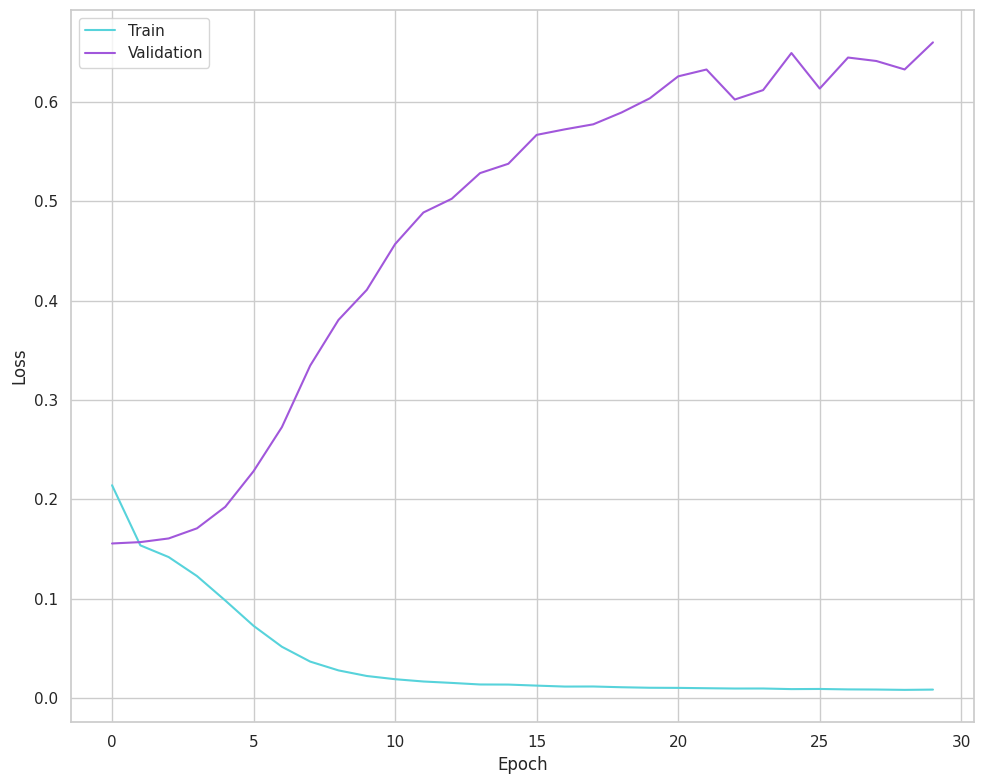

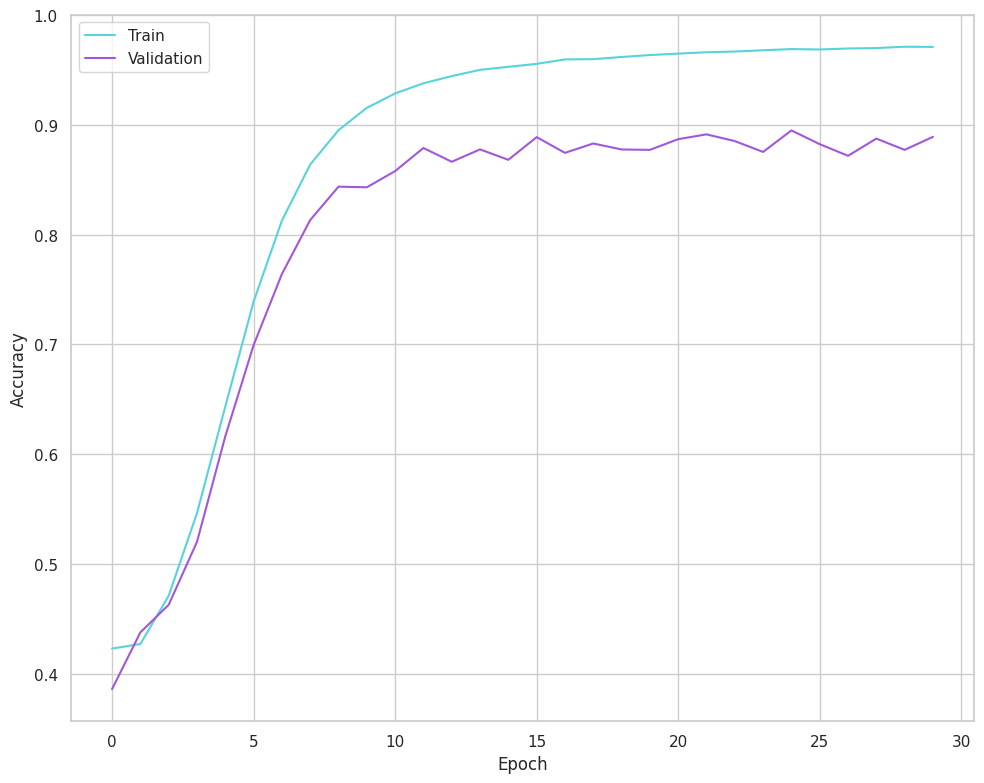

In [ ]:
# Plot Loss and Accuracy 
palette = sns.color_palette("hls", 4)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# Plot Loss

sns.lineplot(x=range(num_epochs), y=train_losses, label='Train', color=palette[2])
sns.lineplot(x=range(num_epochs), y=val_losses, label='Validation', color=palette[3])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig('loss_custom_cnn.png')
plt.show()



# Plot Accuracy
plt.figure(figsize=(10, 8))
sns.lineplot(x=range(num_epochs), y=train_accuracies, label='Train', color=palette[2])
sns.lineplot(x=range(num_epochs), y=val_accuracies, label='Validation', color=palette[3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('accuracy_custom_cnn.png')
plt.show()

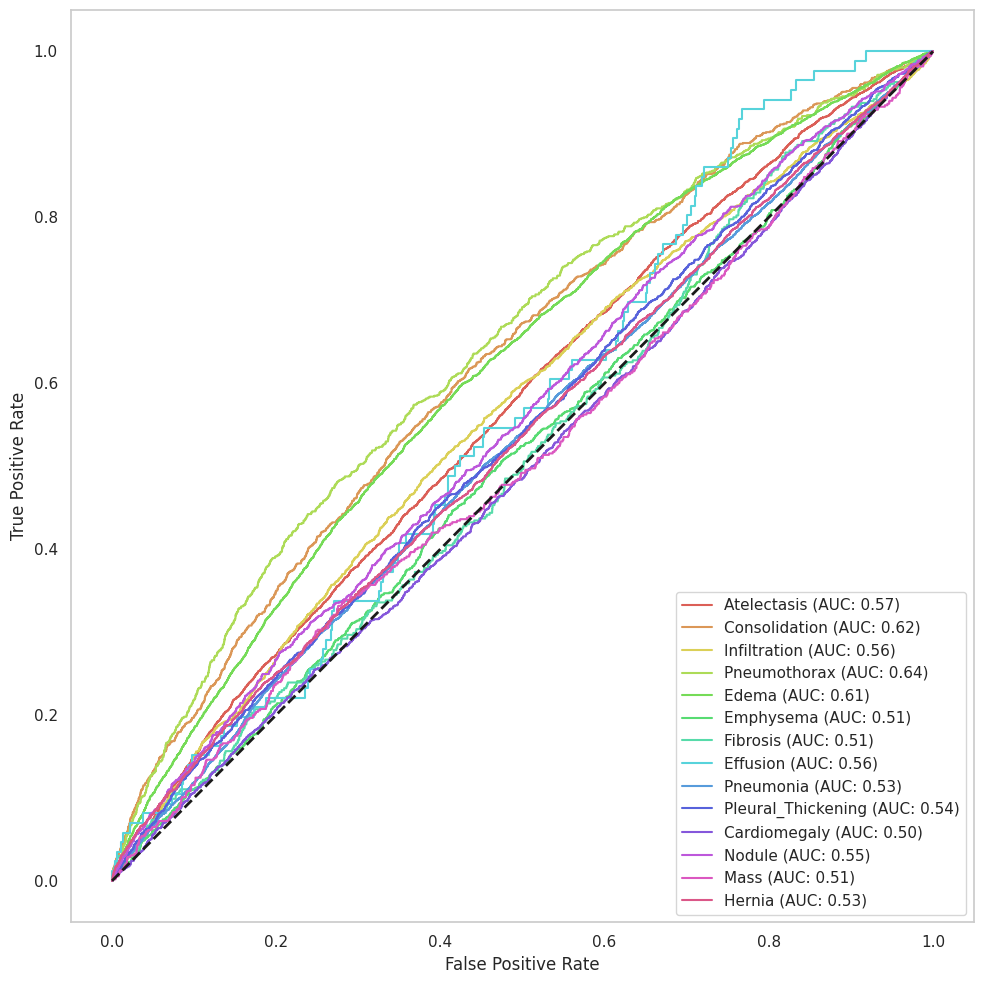

In [12]:
# Plot AUROC
from sklearn.metrics import roc_curve, auc
palette = sns.color_palette("hls", len(class_names))
plt.figure(figsize=(10, 10))

for i, (class_name, color) in enumerate(zip(class_names, palette)):
    fpr, tpr, _ = roc_curve(test_labels[:, i], test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{class_name} (AUC: {roc_auc:.2f})")
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig('auc_cnn.png')
plt.show()